# Strategy creation workflow

In [2]:
import time
import math
import datetime
import connect as ibc
import pandas as pd
from ib_insync import *

import numpy as np
util.startLoop()  # uncomment this line when in a notebook

## Establish connection to IB

In [34]:
ib = IB()
ib.connect('127.0.0.1', 7497, clientId=1)

<IB connected to 127.0.0.1:7497 clientId=1>

## Download the last ticks and create a dataframe

In [35]:
contract = Forex('EURUSD')
ib.qualifyContracts(contract)

[Forex('EURUSD', conId=12087792, exchange='IDEALPRO', localSymbol='EUR.USD', tradingClass='EUR.USD')]

In [36]:
detail = ib.reqContractDetails(contract)
print('Minimum Tick increment possible =',detail[0].minTick)

Minimum Tick increment possible = 5e-05


In [3]:
def get_historical_data(lb_hours: int) -> pd.DataFrame:
    """
    This function will download all tick data until now from x hours / minutes ago 
    and stores the bid/ask sizes as well as prices in a pd.DataFrame.

    :lb_hours: (int) how many hours to "lookback" and get the data from.
    :return: pd.DataFrame containing tick data.
    """
    data = []

    start = datetime.datetime.now() - datetime.timedelta(hours=lb_hours) # This should be changed if a different lookback is wished.
    end = ''
    ticks = ib.reqHistoricalTicks(contract, start, end, 1000, 'BID_ASK', useRth=False)
    data.extend(ticks)
    actual_end = datetime.datetime.now(tz=datetime.timezone.utc)
    while data[-1].time <= actual_end:
        start = data[-1].time
        ticks = ib.reqHistoricalTicks(contract, start, end, 1000, 'BID_ASK', useRth=False)
        data.extend(ticks)
        print(data[-1].time)
    print('Download finished')
    df = []
    for tick in data:
        df.append([tick.time, tick.sizeBid, tick.priceBid, tick.priceAsk, tick.sizeAsk])
    df = pd.DataFrame(df)
    df.columns = ['time', 'bidSize', 'bid', 'ask', 'askSize']
    return df

In [327]:
df = get_historical_data(10)

2021-06-06 23:42:22+00:00
2021-06-06 23:59:08+00:00
2021-06-07 00:01:56+00:00
2021-06-07 00:03:36+00:00
2021-06-07 00:05:34+00:00
2021-06-07 00:06:54+00:00
2021-06-07 00:08:48+00:00
2021-06-07 00:10:55+00:00
2021-06-07 00:14:59+00:00
2021-06-07 00:19:14+00:00
2021-06-07 00:23:10+00:00
2021-06-07 00:29:51+00:00
2021-06-07 00:40:22+00:00
2021-06-07 00:46:07+00:00
2021-06-07 00:49:57+00:00
2021-06-07 00:52:37+00:00
2021-06-07 00:54:47+00:00
2021-06-07 00:57:32+00:00
2021-06-07 01:00:55+00:00
2021-06-07 01:02:10+00:00
2021-06-07 01:03:47+00:00
2021-06-07 01:05:03+00:00
2021-06-07 01:07:02+00:00
2021-06-07 01:08:49+00:00
2021-06-07 01:11:02+00:00
2021-06-07 01:13:15+00:00
2021-06-07 01:16:30+00:00
2021-06-07 01:20:56+00:00
2021-06-07 01:25:05+00:00
2021-06-07 01:30:38+00:00
2021-06-07 01:32:35+00:00
2021-06-07 01:34:43+00:00
2021-06-07 01:38:22+00:00
2021-06-07 01:40:37+00:00
2021-06-07 01:42:08+00:00
2021-06-07 01:44:37+00:00
2021-06-07 01:48:17+00:00
2021-06-07 01:51:44+00:00
2021-06-07 0

In [328]:
def round_down(x: float, a: float) -> float:
    """
    Rounding function to create limit prices that are in line
    with the minimum tick size of IB as seen in the tests.ipynb.

    :param x: (float) current limit price
    :param a: (float) base where we want to round to 

    :return: (float) rounded limit price
    """
    return round(round(x / a) * a, -int(math.floor(math.log10(a))))

def round_up(x: float, a: float) -> float:
    """
    complement of round_down function that uses the original and 
    adds back the base.
    
    :param x: (float) current limit price
    :param a: (float) base where we want to round to 

    :return: (float) rounded limit price
    """
    return (round_down(x, a)+a)

<AxesSubplot:label='d1b81e49-6a25-4119-9c2c-034a37aab7c9'>

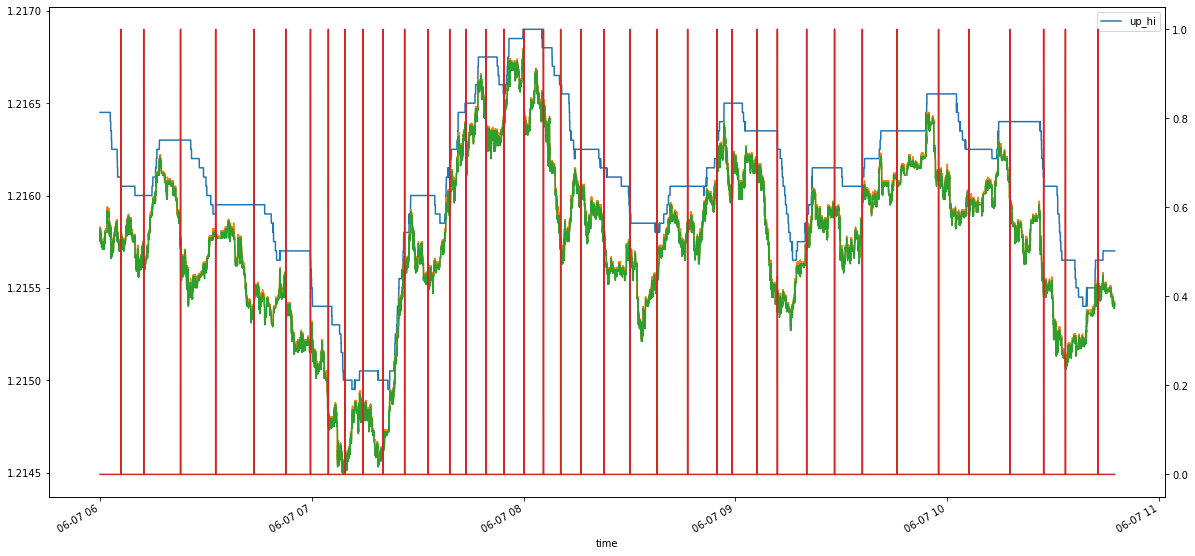

In [455]:
min_tick = detail[0].minTick
df['look'] = np.where(df.index%5000==0, 1, 0)
df['mid'] = (df.ask + df.bid) / 2
df['upper'] = round_up(df.ask, min_tick)+1*min_tick
df['lower'] = round_down(df.bid, min_tick)-1*min_tick
df['up_hi'] = df.upper.rolling(5000).max()
plt_df = df.copy()
plt_df = plt_df.set_index('time')

plt_df = plt_df['2021-06-07 06:00:00':]

plt_df.up_hi.plot(figsize=(20,10), legend=True)
#plt_df.lower.plot(legend=True)
plt_df.ask.plot()
plt_df.bid.plot()
plt_df.look.plot(secondary_y = True)

## Create a Strategy and Backtest it 

In [459]:
def backtest(temp: pd.DataFrame, tx_cost: float):
    """
    Long-only backtesting function. The values and decisions need to be changed 
    while designing your own strategy (such as thres, row['YOUR INDICATOR'], etc.).

    :param temp: pd.dataframe containing the columns mentioned.
    :param tx_cost: percentage costs of a transaction. Will be deducted at every trade.
    :return: pd.DataFrame containing the same columns as the original one but now with added returns and cum_returns.
    """
    long = False
    
    trades = 0
    profit = 0.0001
    sl = 0.00005

    up_thres = 20
    low_thres = 0

    amount = 1    
    long_price = None
    ret = []
    
    for index, row in temp.iterrows():
        
        if index%250 == 0:
            #up_thres = df.upper[(index-3000):index].max()
            #low_thres = row['lower']
            up_thres = row['up_hi']

        if up_thres <= row['ask'] and not long:
            
            print('{} Long {} {} '.format(index, row['ask'], row['upper']))
            trades += 1
            long = True
            long_price = row['ask']
            tp_thres = long_price+profit
            sl_thres = long_price-sl
            ret.append(tx_cost)   
            
        elif (long and tp_thres <= row['bid']) or (long and sl_thres >= row['bid']):
        #elif (long and tp_thres <= row['bid']):

            print('{} Close Long {} {}'.format(index, row['bid'], row['lower']))
            long = False
            long_ret = ((100 / long_price * row['bid']) - 100) / 100 * amount
            ret.append(long_ret)  
            
        elif long:

            long_ret = ((100 / long_price * row['ask']) - 100) / 100 * amount
            long_price = row['ask']
            ret.append(long_ret)
            
        else:
            ret.append(0)

    temp['returns'] = ret
    temp['cum_returns'] = (1+temp.returns).cumprod()
    
    print(trades, 'trades were made')
    print('backtest finished')
    return temp

In [460]:
ret = backtest(df[(len(df)-len(plt_df)):].reset_index(), 0)
ret = ret.set_index('time')

10957 Long 1.21611 1.2162000000000002 
11580 Close Long 1.21621 1.2161499999999998
56171 Long 1.21511 1.2152000000000003 
56606 Close Long 1.21521 1.21515
58733 Long 1.21566 1.21575 
58881 Close Long 1.2156 1.21555
67396 Long 1.21586 1.2159500000000003 
67634 Close Long 1.21596 1.2159
149642 Long 1.21596 1.2160500000000003 
150585 Close Long 1.21589 1.2158499999999999
193246 Long 1.21551 1.2156000000000002 
193502 Close Long 1.21545 1.2153999999999998
6 trades were made
backtest finished


<AxesSubplot:label='af3d3764-517a-49fe-8686-aa2928e11b02'>

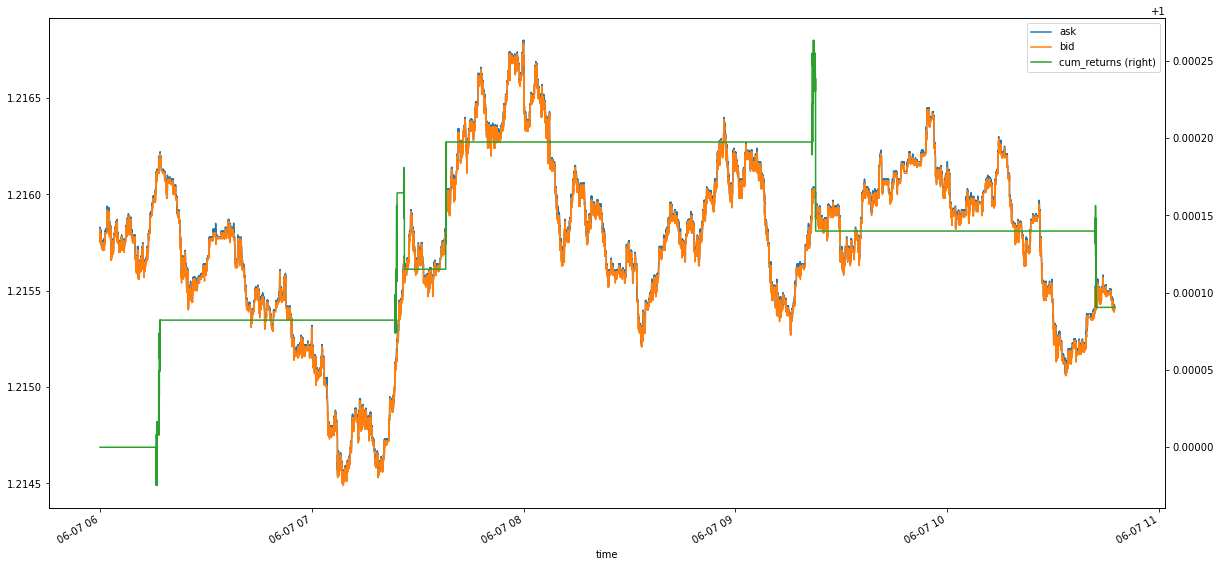

In [461]:
plt_df.ask.plot(figsize=(20,10), legend=True)
plt_df.bid.plot(legend=True)
ret.cum_returns.plot(secondary_y = True, legend=True)

## Small introduction to a OB-Impalance strategy

In [463]:
df['ratio'] = (df.bidSize / (df.askSize+df.bidSize))
df['spread'] = df.ask - df.bid
df['bid_lagged'] = df.bid.shift(50)
df['ratio_ma'] = df.ratio.rolling(100).mean()

<AxesSubplot:label='e4ff5a3b-6619-4023-8041-5a8981d2d0d8'>

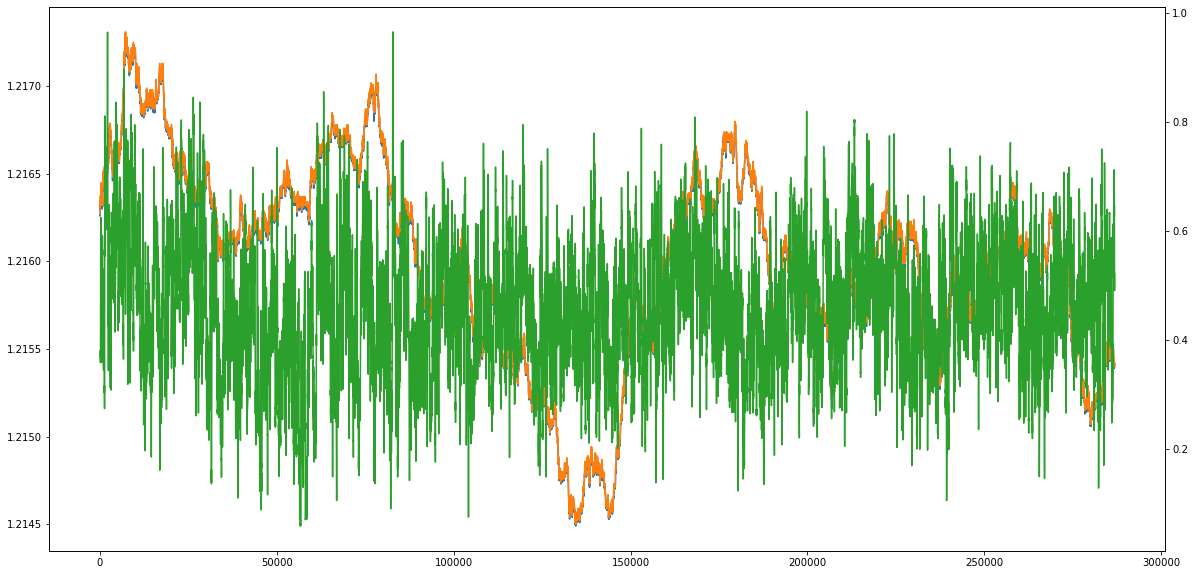

In [464]:
df.bid.plot(figsize=(20,10))
df.ask.plot()
#df.bid.shift(50).plot()
df.ratio_ma.plot(secondary_y=True)

## Disconnect from IB

In [465]:
ib.disconnect()